# Deep Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
import random
from sklearn.preprocessing import StandardScaler

from project_helper import *

## Separate Data Subsets

In [2]:
# read source data
df = pd.DataFrame.from_csv('../data/merged/all_data_2006_to_2016.csv', index_col=None)

In [3]:
# seed for consistent splits
random.seed(1636)

# all idxs
idxs = list(range(len(df)))

# shuffle and split
random.shuffle(idxs)
split = int(len(idxs)*0.7)
train_all = idxs[:split]
test_all = idxs[split:]

# idxs of outliers
outlier_idxs = list((df.MSA_abbr == 'NEW_ORLEANS_LA').nonzero()[0])
outlier_idxs += list(((df.MSA_abbr == 'MEMPHIS_TN') & (df.year == 2016)).nonzero()[0])
outlier_idxs += list(((df.MSA_abbr == 'BATON_ROUGE_LA') & (df.year == 2007)).nonzero()[0])

# cleaned idxs
train_idxs = [idx for idx in train_all if idx not in outlier_idxs]
test_idxs = [idx for idx in test_all if idx not in outlier_idxs]

In [4]:
# get labels because these don't need to change

label = 'murder_per_100_k'
y = df[label]

y_train = y.iloc[train_idxs]
y_test = y.iloc[test_idxs]

print('Train Len:\t {} \nTest Len:\t {}'.format(len(y_train),len(y_test)))

Train Len:	 640 
Test Len:	 276


In [5]:
# drop irrelevant columns
x_features_df = df.drop(['MSA_orig', 'MSA_corr', 'MSA_abbr', 'murder_per_100_k'], axis=1)

# standardize, fitting only on training rows
standardizer = StandardScaler().fit(x_features_df.iloc[train_idxs])
x_features = pd.DataFrame(standardizer.transform(x_features_df), columns=x_features_df.columns)

# train test split
x_train = x_features.iloc[train_idxs]
x_test = x_features.iloc[test_idxs]

print('Train X and y match: {}'.format(len(x_train)==len(y_train)))
print('Test  X and y match: {}'.format(len(x_test)==len(y_test)))
print('\nNumber of Predictors: {}'.format(len(x_train.columns)))

print('\nFEATURE NAMES:')
for name in x_train.columns:
    print(' -'+name)

Train X and y match: True
Test  X and y match: True

Number of Predictors: 9

FEATURE NAMES:
 -year
 -now_married_except_separated
 -less_than_high_school_diploma
 -unmarried_portion_of_women_15_to_50_years_who_had_a_birth_in_past_12_months
 -households_with_food_stamp_snap_benefits
 -percentage_married-couple_family
 -percentage_female_householder_no_husband_present_family
 -poverty_all_people
 -house_median_value_(dollars)


## Fitting The Models

In [6]:
from keras.layers import Dense
from keras.models import Sequential
from keras import backend as K
from sklearn.metrics import r2_score

Using TensorFlow backend.


In [7]:
def regression_dnn(n_layers, layer_width):
    '''
    Makes a simple feed forward network with n_layers identical
    layers, each of width layer_width
    '''
    
    model = Sequential()
    
    # input layer
    model.add(Dense(layer_width, activation='elu', input_dim=9))
    
    # add more layers
    for i in range(n_layers-1):
        model.add(Dense(layer_width, activation='elu'))
        
    # output layer
    model.add(Dense(1, activation=None))
    
    # return model
    return model

In [8]:
class keras_wrapper:
    '''
    Wraps a keras regression model for minimal compatibility
    with sklearn APIs such that it will work with our bootstrap
    procedure. 
    '''
    
    def __init__(self, n_layers, layer_width, model_gen):
        # can accept different model types via different
        # generating functions
        self.model = model_gen(n_layers, layer_width)

    def fit(self, x_train, y_train):
        # compiles and fits the model, returns self
        self.model.compile(loss='mse', optimizer='nadam')
        _ = self.model.fit(x_train, y_train, epochs=10, verbose=0)
        return self
        
    def score(self, X, y):
        # uses sklearn r2_score function
        preds = self.model.predict(X)
        return r2_score(y, preds)

In [9]:
# instantiate and fit models
def make_models(x_train, y_train):
    md = dict()

    # reset tensorflow graph for performance
    K.clear_session()
    
    md['dnn_1'] = keras_wrapper(1,16, regression_dnn).fit(x_train, y_train)
    md['dnn_2'] = keras_wrapper(2,16, regression_dnn).fit(x_train, y_train)
    md['dnn_3'] = keras_wrapper(4,32, regression_dnn).fit(x_train, y_train)
    md['dnn_4'] = keras_wrapper(8,32, regression_dnn).fit(x_train, y_train)
    md['dnn_5'] = keras_wrapper(16,32, regression_dnn).fit(x_train, y_train)
    
    return md

In [10]:
# run the model to estimate parameters

exp_1 = run_experiment(make_models, 100, x_train.values, y_train.values, x_test.values, y_test.values)

100%|██████████| 100/100 [31:34<00:00, 19.10s/it]


### Accuracy Results

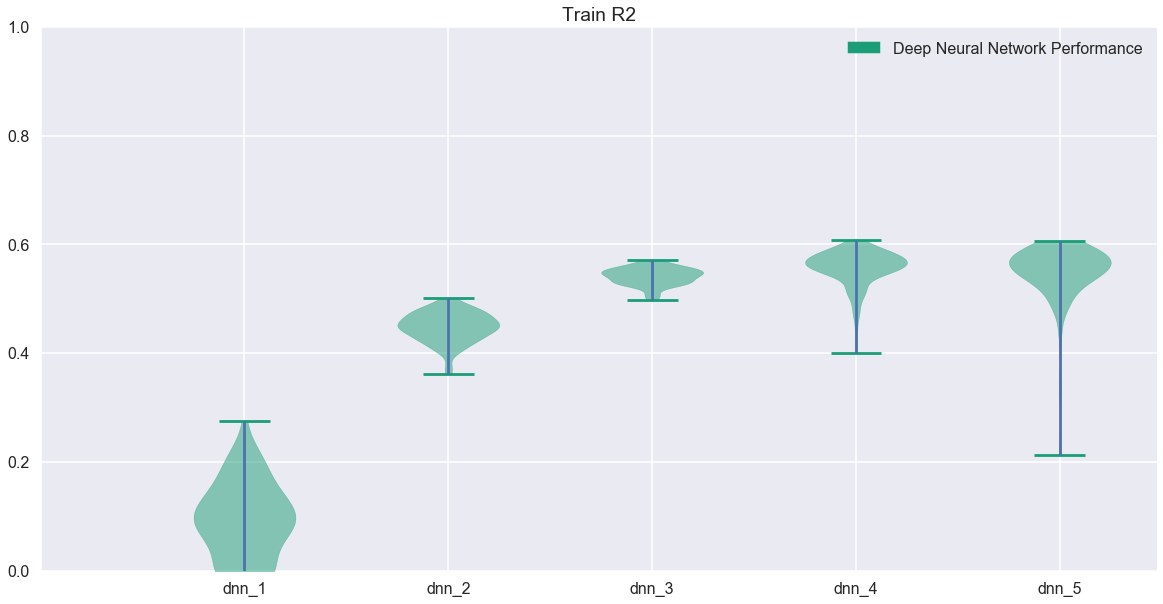

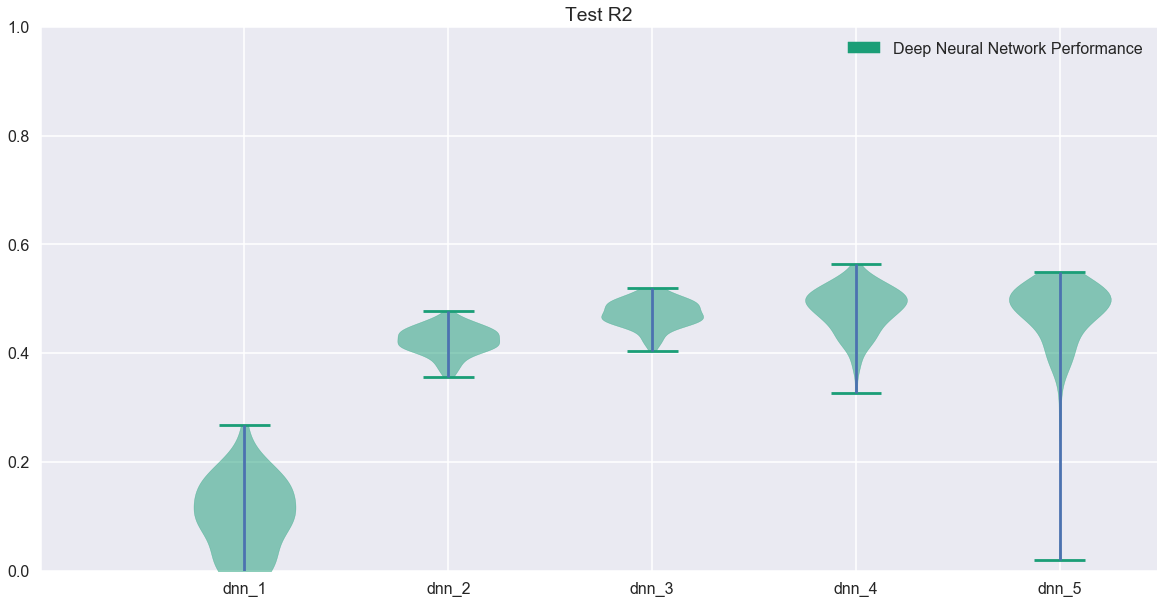

In [12]:
violin_plots(exp_1, ['Train R2','Test R2'], experiment_name='Deep Neural Network Performance', center_zero=False)